In [5]:
import pandas as pd
import numpy as np

In [6]:
def openFile(file) -> pd.DataFrame:
    return pd.read_table(file, header = [3], encoding = 'ANSI', sep = ',')


In [8]:
filedata = openFile('data/Extrudat20230818_13.TRA')
filedata

,s,N,mm,mm.1
0,0.019932,0.016736,0.000012,90.0000
1,0.079932,0.050880,0.000012,90.0000
2,0.099932,0.033807,0.000012,90.0000
3,0.519932,-0.000336,0.000012,90.0000
4,0.659932,-0.017408,0.014358,90.0143
...,...,...,...,...
3445,107.840000,1.365420,53.602000,143.6020
3446,107.880000,1.365420,53.621900,143.6220
3447,107.920000,1.365420,53.640500,143.6400
3448,108.600000,1.348350,53.650000,143.6500


In [9]:
def getStrain(data) -> pd.Series:
    return np.log(filedata['mm.1'] / filedata['mm.1'][0])

def getStress(data) -> pd.Series:
    return filedata['N']

In [10]:
def getStressStrain(data) -> pd.DataFrame:

    df = pd.DataFrame({'strain': getStrain(data), 'stress': getStress(data)})
    
    max_stress_row = df[df['stress'] == df['stress'].max()]
    max_strain_index = max_stress_row.index[0]

    cut_df = df.iloc[:max_strain_index + 1]

    return cut_df

In [11]:
stress = getStressStrain(filedata)

In [12]:
def getBestFit(stressData, window = 500):
    step = 10
    
    left = 0
    right = window
    coeff = pd.DataFrame()
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    lengthStressData = len(stressData)
    
    while True:
        if right > lengthStressData: 
            break

        data = stressData[left:right]

        model.fit(data[['strain']], data[['stress']])
        slope = model.coef_[0]
        intercept = model.intercept_
        y_exp = slope * data['strain'] + intercept
        error = (data['stress'] - y_exp)**2

        coeff = pd.concat([coeff, pd.DataFrame({'strain': data.iloc[100].strain, 'slope': slope, 'intercept': intercept, 'error': error.sum()})],axis=0)

        left += step
        right += step
        
    bestFit = coeff[coeff['error'] == coeff['error'].min()].iloc[0]
    return bestFit

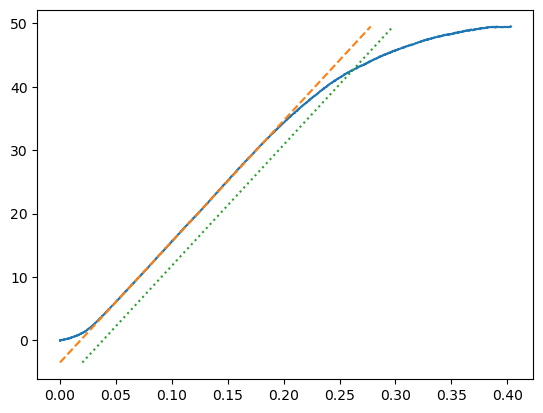

In [13]:
def plotStressStrain(data):
    import matplotlib.pyplot as plt
    plt.plot(data['strain'], data['stress'])
    return plt

import matplotlib.pyplot as plt

plotStressStrain(stress)
best = getBestFit(stress)

max_stress = stress[-1:]['stress'].values[0]

max_strain = (max_stress - best.intercept) / best.slope
limited_strain = stress[stress['strain'] < max_strain]['strain']

line = best.slope * limited_strain + best.intercept
other = best.slope * (limited_strain) + best.intercept

plt.plot(limited_strain, line, linestyle='--')
plt.plot(limited_strain + 0.02, other, linestyle='dotted')

In [14]:
max_stress = stress[-1:]['stress'].values[0]
max_strain = (max_stress - best.intercept) / best.slope
limited_strain = stress[stress['strain'] < max_strain]['strain']


In [17]:
stress['stress'].max()

49.5084